In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import joblib
import os



In [18]:
# Step 1: Load the CSV dataset
csv_filename = 'finalcopy copy.csv'
try:
    df = pd.read_csv(csv_filename)
    print(f"Loaded dataset with {len(df)} rows and {len(df.columns)} columns.")
except FileNotFoundError:
    print(f"Error: {csv_filename} not found.")
    exit(1)

df.head()

Loaded dataset with 5024 rows and 27 columns.


,timestamp,Ax_mean,Ay_mean,Az_mean,Gx_mean,Gy_mean,Gz_mean,Ax_var,Ay_var,Az_var,...,nh4_mean,acetone_mean,co_var,co2_var,alcohol_var,toluen_var,nh4_var,acetone_var,sample_count,mean_bpm
0,2025-04-17 10:33:46,1.083317,0.046831,-0.054448,-0.216876,-0.145038,-0.290213,0.002138,0.000561,0.000148,...,4.370625,0.471250,0.022545,0.006243,0.001800,0.000453,0.010953,0.000278,56,67.926109
1,2025-04-17 10:33:49,1.082699,0.048608,-0.061792,-0.410051,-0.209160,-0.269975,0.000201,0.000788,0.000368,...,4.293542,0.459792,0.016415,0.004656,0.001170,0.000300,0.007755,0.000172,60,67.725201
2,2025-04-17 10:33:52,1.082182,0.032922,-0.054252,-0.149364,-0.120102,-0.275573,0.000167,0.000268,0.000211,...,4.320909,0.463636,0.003682,0.001136,0.000336,0.000046,0.001809,0.000046,60,67.558330
3,2025-04-17 10:33:55,1.082540,0.037528,-0.054252,-0.124046,-0.147837,-0.273537,0.000124,0.000868,0.000114,...,4.347209,0.467907,0.001758,0.000543,0.000172,0.000022,0.000835,0.000022,60,67.423330
4,2025-04-17 10:33:58,1.082874,0.047205,-0.050509,-0.001272,-0.144656,-0.273410,0.000159,0.000632,0.000283,...,4.356000,0.469333,0.000513,0.000158,0.000057,0.000006,0.000228,0.000006,60,67.318032


In [19]:
# Step 2: Preprocess the data
# Drop non-numerical column 'timestamp' and optionally 'sample_count'
df = df.iloc[10:].reset_index(drop=True)
print(f"Dropped first 10 rows. New dataset size: {len(df)} rows.")
features = df.drop(columns=['timestamp', 'sample_count', 'toluen_var', 'nh4_var','acetone_var','toluen_mean', 'nh4_mean','acetone_mean','co_var','co2_var','alcohol_var'])



# Check for missing values
if features.isnull().any().any():
    print("Warning: Missing values detected. Filling with 0.")
    features = features.fillna(0)

gas_features = ['co_mean',  'alcohol_mean', 'co2_mean']
scaling_factor = 0.1  # You can adjust this to control influence

for col in gas_features:
    features[col] = features[col] * scaling_factor

# Convert features to numpy array
X = features.values



Dropped first 10 rows. New dataset size: 5014 rows.


In [20]:
# import matplotlib.pyplot as plt
# # Select only numerical columns
# numeric_df = features.select_dtypes(include=['number'])

# # Compute min, mean, max
# mins = numeric_df.min()
# means = numeric_df.mean()
# maxs = numeric_df.max()

# # Plotting
# plt.figure(figsize=(14, 6))
# x = range(len(numeric_df.columns))

# plt.plot(x, mins, marker='o', label='Min', color='blue')
# plt.plot(x, means, marker='o', label='Mean', color='green')
# plt.plot(x, maxs, marker='o', label='Max', color='red')

# plt.xticks(x, numeric_df.columns, rotation=45, ha='right')
# plt.ylabel("Value")
# plt.title("Min, Mean, and Max of Each Numerical Column")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [21]:
# Step 3: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features scaled using StandardScaler.")



Features scaled using StandardScaler.


In [22]:
X_scaled

array([[ 0.3300821 , -0.4220973 , -0.84321517, ..., -1.02212056,
        -0.97656858, -0.73842535],
       [ 0.13939017, -0.14157102, -0.8773708 , ..., -1.02417169,
        -0.97823273, -0.73672102],
       [ 0.14655902, -0.39049905, -0.80398037, ..., -1.02712772,
        -0.98043913, -0.73451411],
       ...,
       [ 1.02299215, -0.83367586,  0.0864122 , ..., -0.61202206,
        -0.62576678,  0.49395057],
       [-0.67337794,  2.95845768, -0.47736649, ..., -1.06694173,
        -1.00788811,  0.50493269],
       [ 0.42723212,  0.43134688, -0.95564852, ...,  2.58751798,
         2.64717228,  0.51821711]])

In [23]:
# Step 4: Train Isolation Forest model
# Configure Isolation Forest: contamination is the expected proportion of anomalies
contamination = 0.05 # Assume ~10% of data are anomalies (adjust as needed)
model = IsolationForest(contamination=contamination, random_state=42, n_estimators=100)
model.fit(X_scaled)
print("Isolation Forest model trained.")



Isolation Forest model trained.


In [24]:
# Step 5: Predict anomalies on the dataset (for evaluation)
# -1 indicates anomaly, 1 indicates normal
predictions = model.predict(X_scaled)
df['anomaly'] = predictions
df['anomaly'] = df['anomaly'].map({1: 'Normal', -1: 'Anomaly'})
anomaly_count = (predictions == -1).sum()
print(f"Found {anomaly_count} anomalies out of {len(df)} samples "
      f"({anomaly_count/len(df)*100:.2f}%).")



Found 251 anomalies out of 5014 samples (5.01%).


In [25]:
feature_names = features.columns
# Step 6: Analyze anomalies
normal_data = features[df['anomaly'] == 'Normal']
anomaly_data = features[df['anomaly'] == 'Anomaly']

# Compute statistics for normal data
normal_stats = normal_data.describe().loc[['mean', 'std']]

print("\nNormal data statistics (mean ± std):")
for col in normal_stats.columns:
    mean, std = normal_stats[col]['mean'], normal_stats[col]['std']
    print(f"{col}: {mean:.6f} ± {std:.6f}")

print("\nAnalyzing anomalies:")
for idx in anomaly_data.index[:]:  # Limit to first 5 for brevity
    print(f"\nAnomaly at index {idx}, timestamp {df.loc[idx, 'timestamp']}:")
    anomaly_row = anomaly_data.loc[idx]
    z_scores = (anomaly_row - normal_stats.loc['mean']) / normal_stats.loc['std']
    print("Feature values and z-scores (how many std devs from normal mean):")
    for feat, val, z in zip(feature_names, anomaly_row, z_scores):
        print(f"  {feat}: {val:.6f} (z-score: {z:.2f})")
    # Highlight significant deviations
    significant = z_scores[abs(z_scores) > 2]
    if not significant.empty:
        print("  Significant deviations (|z-score| > 2):")
        for feat, z in significant.items():
            print(f"    {feat}: z-score = {z:.2f}")


Normal data statistics (mean ± std):
Ax_mean: 1.079919 ± 0.010505
Ay_mean: 0.041220 ± 0.043285
Az_mean: -0.009530 ± 0.051502
Gx_mean: -0.184080 ± 0.274250
Gy_mean: -0.164130 ± 0.088092
Gz_mean: -0.275244 ± 0.048852
Ax_var: 0.005977 ± 0.006681
Ay_var: 0.003311 ± 0.003099
Az_var: 0.002954 ± 0.002905
Gx_var: 0.171826 ± 0.230459
Gy_var: 0.424246 ± 0.299768
Gz_var: 0.150692 ± 0.157064
co_mean: 5.159428 ± 5.321871
co2_mean: 41.658045 ± 1.322081
alcohol_mean: 0.974858 ± 0.847592
mean_bpm: 85.116564 ± 24.082691

Analyzing anomalies:

Anomaly at index 25, timestamp 2025-04-17 10:35:56:
Feature values and z-scores (how many std devs from normal mean):
  Ax_mean: 1.082178 (z-score: 0.21)
  Ay_mean: 0.030123 (z-score: -0.26)
  Az_mean: -0.125944 (z-score: -2.26)
  Gx_mean: 1.200891 (z-score: 5.05)
  Gy_mean: -0.213359 (z-score: -0.56)
  Gz_mean: -0.495929 (z-score: -4.52)
  Ax_var: 0.012014 (z-score: 0.90)
  Ay_var: 0.007770 (z-score: 1.44)
  Az_var: 0.014047 (z-score: 3.82)
  Gx_var: 1.031613 (z


SHAP Feature Impact on Detected Anomalies:

Anomaly at index 25, timestamp 2025-04-17 10:35:56:


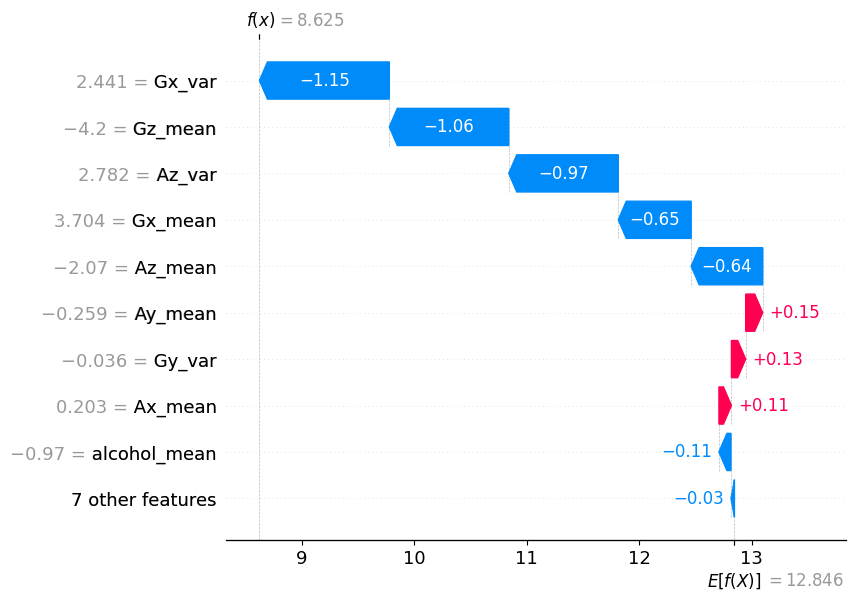


Anomaly at index 26, timestamp 2025-04-17 10:35:59:


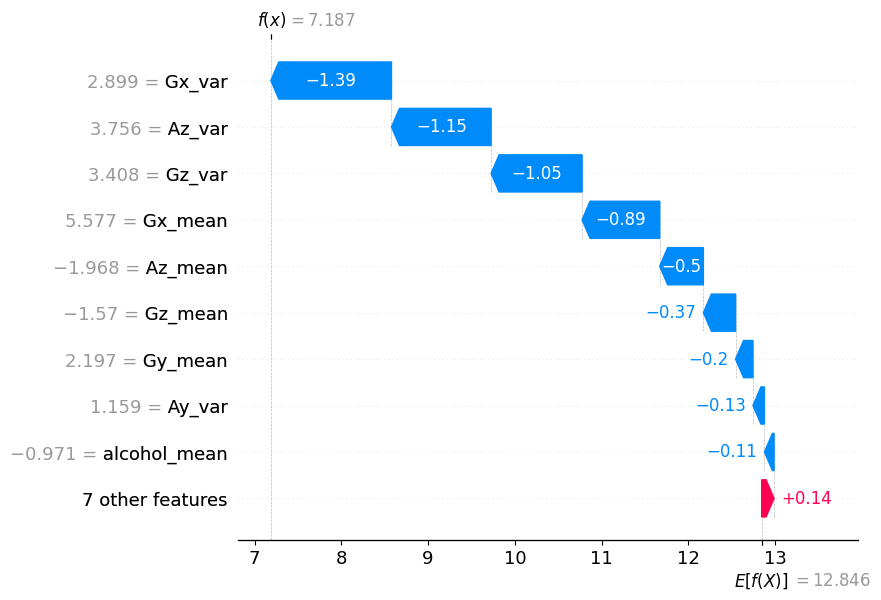


Anomaly at index 37, timestamp 2025-04-17 10:36:32:


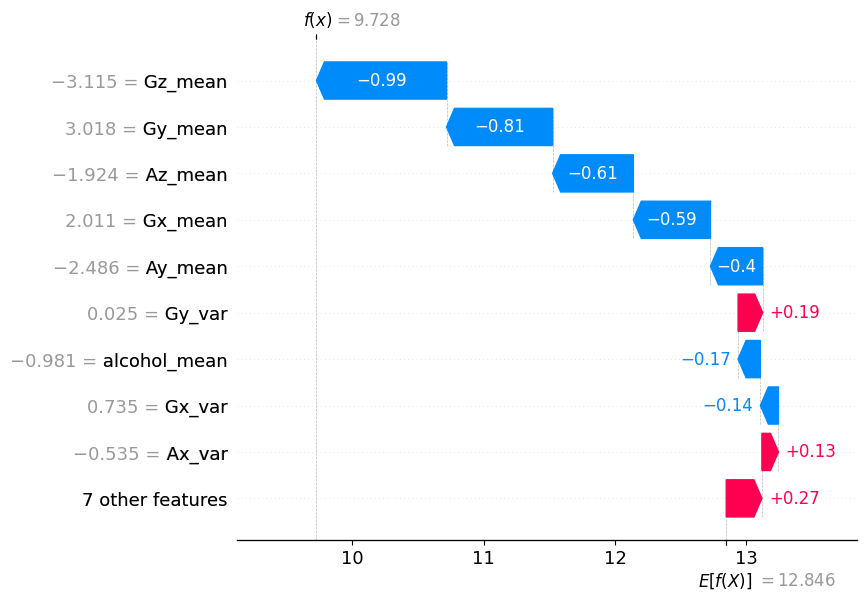

In [26]:
import shap

# Step 1: Use TreeExplainer with your tree-based model
explainer = shap.TreeExplainer(model)

# Step 2: Compute SHAP values
shap_values = explainer.shap_values(X_scaled)

# Step 3: Select anomaly indices
anomalies_idx = np.where(predictions == -1)[0][:3]  # First 3 anomalies

# Step 4: Display waterfall plots
print("\nSHAP Feature Impact on Detected Anomalies:")
for idx in anomalies_idx:
    print(f"\nAnomaly at index {idx}, timestamp {df.loc[idx, 'timestamp']}:")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[idx],
            base_values=explainer.expected_value,
            data=X_scaled[idx],
            feature_names=feature_names
        ),
        max_display=10,
        show=True
    )


In [27]:
import shap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Compute SHAP values
explainer = shap.Explainer(model, X_scaled)
shap_values = explainer(X_scaled)

# Get mean absolute SHAP values to rank feature importance
shap_array = shap_values.values  # shape: (n_samples, n_features)
top_features = np.argmax(np.abs(shap_array), axis=1)

# Optionally get the actual SHAP value (strength of impact) of the top feature
top_shap_values = np.max(np.abs(shap_array), axis=1)

# t-SNE projection
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Convert to DataFrame for easier plotting
tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['TopFeatureIndex'] = top_features
tsne_df['SHAPStrength'] = top_shap_values
tsne_df['Anomaly'] = df['anomaly'].values  # Add labels

# Optional: map feature index to name
feature_names = features.columns.tolist()
tsne_df['TopFeatureName'] = tsne_df['TopFeatureIndex'].apply(lambda i: feature_names[i])


 99%|===================| 4975/5014 [00:18<00:00]        

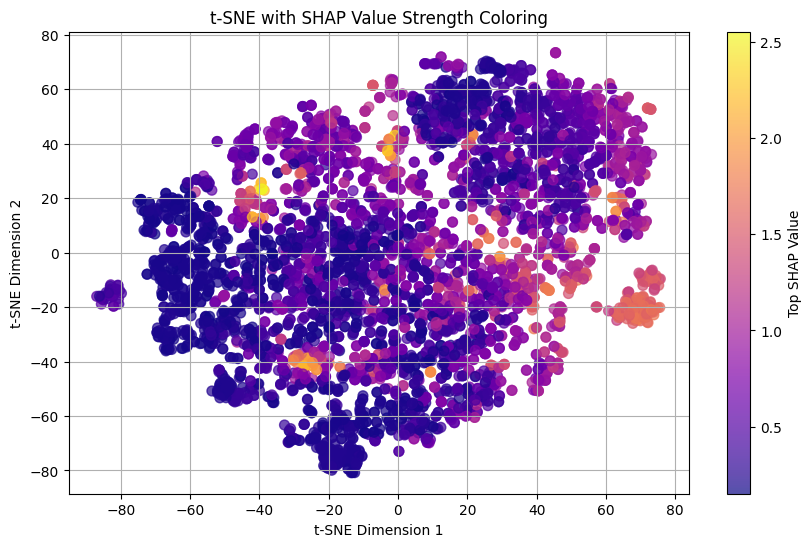

In [28]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    tsne_df['Dim1'], tsne_df['Dim2'],
    c=tsne_df['SHAPStrength'], cmap='plasma', s=50, alpha=0.7
)
plt.colorbar(scatter, label='Top SHAP Value')
plt.title("t-SNE with SHAP Value Strength Coloring")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()


C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


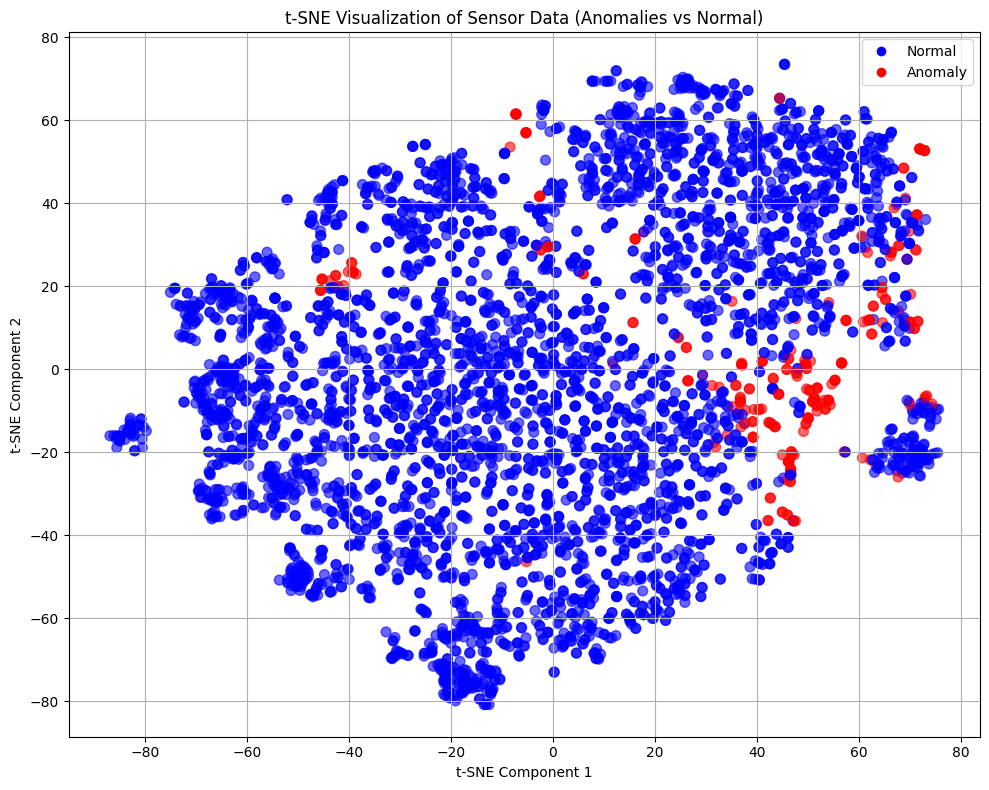

In [29]:
import matplotlib.pyplot as plt


from sklearn.manifold import TSNE

# Step: t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Add t-SNE components to the DataFrame
df['tsne-1'] = X_tsne[:, 0]
df['tsne-2'] = X_tsne[:, 1]

# Plot t-SNE
plt.figure(figsize=(10, 8))
colors = df['anomaly'].map({'Normal': 'blue', 'Anomaly': 'red'})
plt.scatter(df['tsne-1'], df['tsne-2'], c=colors, alpha=0.6, s=50)
plt.title("t-SNE Visualization of Sensor Data (Anomalies vs Normal)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Normal', markerfacecolor='blue', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Anomaly', markerfacecolor='red', markersize=8)
])
plt.tight_layout()
plt.show()

    
    

<Figure size 1000x600 with 0 Axes>

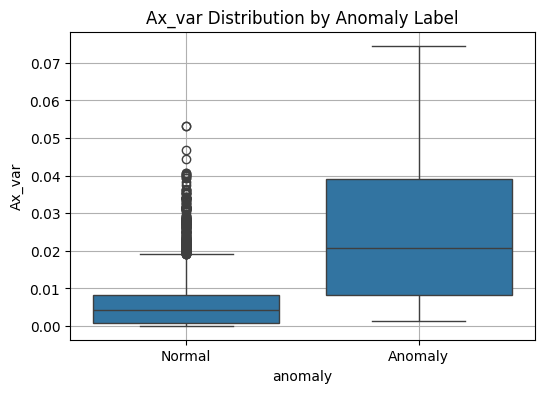

<Figure size 1000x600 with 0 Axes>

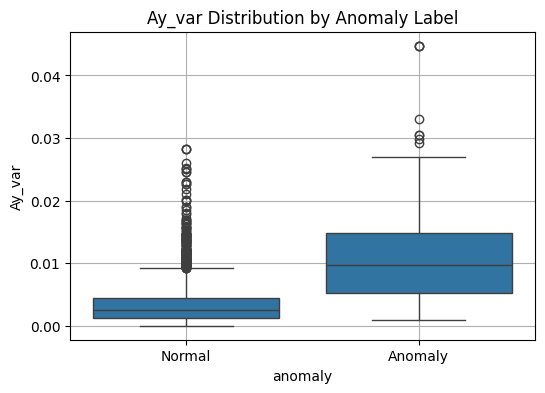

<Figure size 1000x600 with 0 Axes>

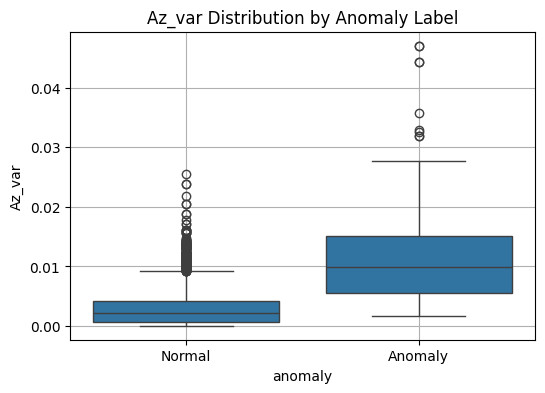

<Figure size 1000x600 with 0 Axes>

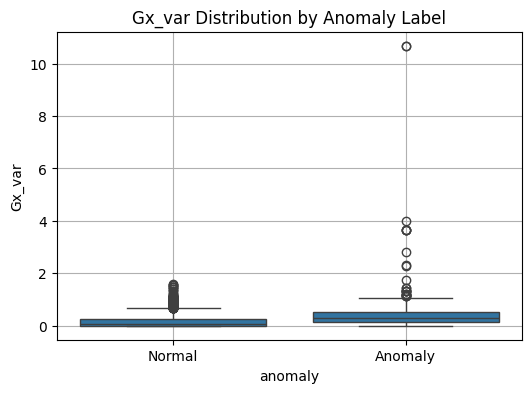

<Figure size 1000x600 with 0 Axes>

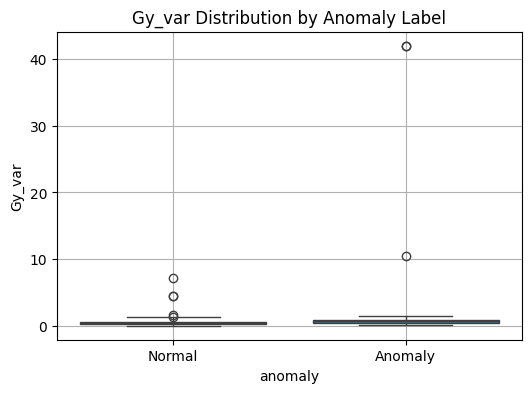

<Figure size 1000x600 with 0 Axes>

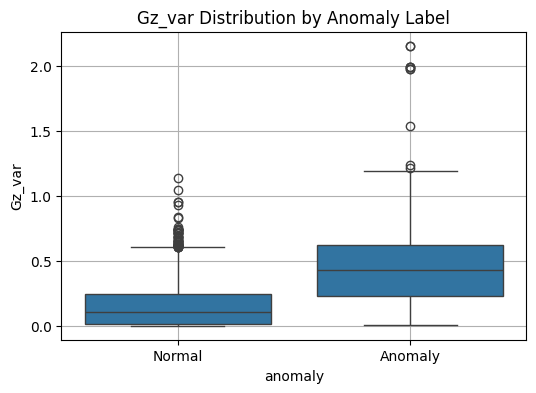

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
for feature in ['Ax_var', 'Ay_var', 'Az_var', 'Gx_var', 'Gy_var', 'Gz_var']:
    
    plt.figure(figsize=(10, 6))
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='anomaly', y=feature, data=df)
    plt.title(f'{feature} Distribution by Anomaly Label')
    plt.grid(True)
    plt.show()


In [31]:
# # Step 6: Save the model and scaler for deployment
# model_filename = 'isolation_forest_model.pkl'
# scaler_filename = 'scaler.pkl'
# joblib.dump(model, model_filename)
# joblib.dump(scaler, scaler_filename)
# print(f"Saved model to {model_filename} and scaler to {scaler_filename}.")

# # Step 7: Save the dataset with anomaly predictions for review
# output_csv = 'sensor_data_with_anomalies.csv'
# df.to_csv(output_csv, index=False, float_format='%.6f')
# print(f"Saved dataset with anomaly labels to {output_csv}.")

# Optional: Print sample of anomalies
print("\nSample of detected anomalies:")
print(df[df['anomaly'] == 'Anomaly'][['timestamp', 'Ax_mean', 'co_mean', 'anomaly']])


Sample of detected anomalies:
                timestamp   Ax_mean     co_mean  anomaly
25    2025-04-17 10:35:56  1.082178    4.556667  Anomaly
26    2025-04-17 10:35:59  1.084367    4.512167  Anomaly
37    2025-04-17 10:36:32  1.079220    4.168500  Anomaly
41    2025-04-17 10:36:44  1.070007    4.116000  Anomaly
51    2025-04-17 10:37:27  1.082153    5.504667  Anomaly
...                   ...       ...         ...      ...
4927  2025-04-17 14:46:00  1.065138  156.676222  Anomaly
4935  2025-04-17 14:46:24  1.083846  112.664116  Anomaly
4975  2025-04-17 14:48:24  1.047652   18.947869  Anomaly
4976  2025-04-17 14:48:27  1.055153  162.525778  Anomaly
4984  2025-04-17 14:48:51  1.072866  198.632467  Anomaly

[251 rows x 4 columns]


In [32]:
import joblib

# Step 6: Save the model and scaler for deployment
model_filename = 'isolation_forest_model.pkl'
scaler_filename = 'scaler.pkl'

joblib.dump(model, model_filename)
joblib.dump(scaler, scaler_filename)

print(f"Saved model to {model_filename} and scaler to {scaler_filename}.")


Saved model to isolation_forest_model.pkl and scaler to scaler.pkl.
